In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from kaggle_calorie_predictor.data.data_object import DataObject

In [4]:
sample_sub = pd.read_csv('../data/sample_submission.csv')
test = pd.read_csv('../data/test.csv')
train = DataObject(file_path='../data/train.csv')

In [6]:
sample_sub.head()

,id,Calories
0,750000,88.283
1,750001,88.283
2,750002,88.283
3,750003,88.283
4,750004,88.283


In [7]:
test.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [4]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,HR_per_Minute,Intensity,Body_Temp_Delta
0,0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,3.884615,3.884615,0.0
1,1,1,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,10.625000,10.625000,-1.3
2,2,1,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,12.000000,12.000000,-1.2
3,3,0,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,4.200000,4.200000,-0.3
4,4,1,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,4.080000,4.080000,-0.4


# EDA

## Missing values

In [13]:
train.info()

<class 'kaggle_calorie_predictor.data.data_object.DataObject'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               750000 non-null  int64  
 1   Sex              750000 non-null  int64  
 2   Age              750000 non-null  int64  
 3   Height           750000 non-null  float64
 4   Weight           750000 non-null  float64
 5   Duration         750000 non-null  float64
 6   Heart_Rate       750000 non-null  float64
 7   Body_Temp        750000 non-null  float64
 8   Calories         750000 non-null  float64
 9   BMI              750000 non-null  float64
 10  Intensity        750000 non-null  float64
 11  Body_Temp_Delta  750000 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 68.7 MB


## Outliers

In [22]:
outliers = train.copy()
for col in outliers.columns:
    if col not in ['id']:
        outliers[col] = stats.zscore(outliers[col])

In [24]:
outliers = outliers[(np.abs(outliers) < 3).all(axis=1)]
outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 0 to 2
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3 non-null      int64  
 1   Sex              3 non-null      float64
 2   Age              3 non-null      float64
 3   Height           3 non-null      float64
 4   Weight           3 non-null      float64
 5   Duration         3 non-null      float64
 6   Heart_Rate       3 non-null      float64
 7   Body_Temp        3 non-null      float64
 8   Calories         3 non-null      float64
 9   BMI              3 non-null      float64
 10  Intensity        3 non-null      float64
 11  Body_Temp_Delta  3 non-null      float64
dtypes: float64(11), int64(1)
memory usage: 312.0 bytes


## Distributions

In [25]:
train.describe()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Intensity,Body_Temp_Delta
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,0.500961,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781,24.374817,10.547400,-0.963747
std,216506.495284,0.499999,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349,1.511310,12.237710,0.779875
min,0.000000,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000,12.375937,2.714286,-3.900000
25%,187499.750000,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000,23.255019,4.521739,-1.400000
50%,374999.500000,1.000000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000,24.391059,6.214286,-0.700000
75%,562499.250000,1.000000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000,25.487697,10.750000,-0.300000
max,749999.000000,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000,46.443986,108.000000,0.500000


In [30]:
print("Shapiro-Wilk test for normality:")
for col in train.columns:
    if col not in ['id']:
        print(f"{col}: {stats.shapiro(train[col])[1]}")

Shapiro-Wilk test for normality:
Sex: 8.688570653605236e-195
Age: 1.999728038181259e-126
Height: 1.5357667564995534e-96
Weight: 5.421874807120597e-116
Duration: 4.5270166108643736e-126
Heart_Rate: 1.7318747730133328e-83
Body_Temp: 1.415730058157336e-145
Calories: 1.2595999521546618e-132
BMI: 1.0707325849042848e-70
Intensity: 2.852354236192763e-203
Body_Temp_Delta: 1.415730058157336e-145


c:\Users\bjham\Documents\programming\venvs\kaggle-calorie-predictor\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 750000.
  res = hypotest_fun_out(*samples, **kwds)


In [31]:
print("Kolmogorov-Smirnov test for normality:")
for col in train.columns:
    if col not in ['id']:
        print(f"{col}: {stats.kstest(train[col], 'norm')[1]}")

Kolmogorov-Smirnov test for normality:
Sex: 0.0
Age: 0.0
Height: 0.0
Weight: 0.0
Duration: 0.0
Heart_Rate: 0.0
Body_Temp: 0.0
Calories: 0.0
BMI: 0.0
Intensity: 0.0
Body_Temp_Delta: 0.0


Not normally distributed

In [32]:
train.skew()

id                -1.963100e-15
Sex               -3.845348e-03
Age                4.363975e-01
Height             5.177712e-02
Weight             2.111939e-01
Duration           2.625895e-02
Heart_Rate        -5.668158e-03
Body_Temp         -1.022361e+00
Calories           5.391963e-01
BMI               -3.291406e-03
Intensity          3.825658e+00
Body_Temp_Delta   -1.022361e+00
dtype: float64

## Correlations

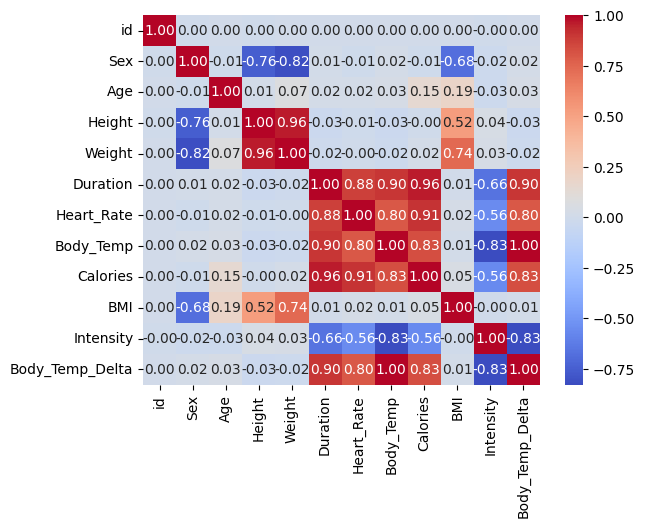

In [14]:
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

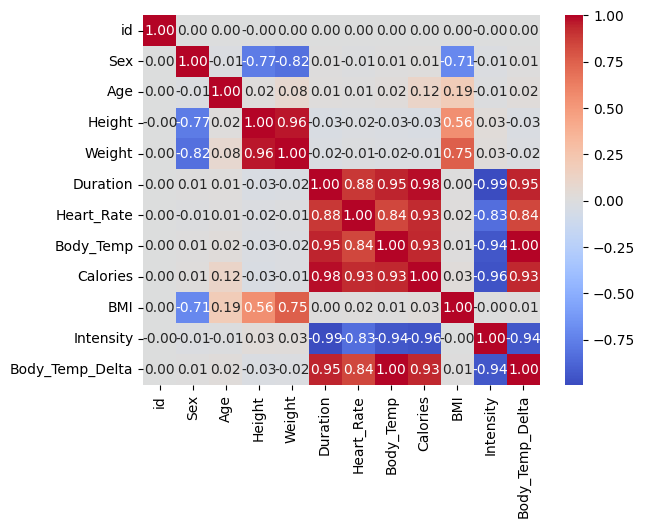

In [35]:
sns.heatmap(train.corr(method='spearman'), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [ ]:
def calculate_mutual_info(X, y):
    mi = mutual_info_regression(X, y)
    return mi


independent_vars = [col for col in train.columns if col not in ['id']]
dependent_vars = independent_vars.copy()
# Initialize a dictionary to store mutual information values
mutual_info_dict = {}

# Calculate mutual information for each pair of variables
for var1 in independent_vars:
    for var2 in dependent_vars:
        X = train[[var1]]
        y = train[var2]
        mutual_info = calculate_mutual_info(X, y)
        mutual_info_dict[(var1, var2)] = mutual_info[0]  # Get the scalar value

# Convert the dictionary to a DataFrame for easier analysis
mutual_info_df = pd.DataFrame(list(mutual_info_dict.items()), columns=['Variable Pair', 'Mutual Information'])

In [15]:
train.info()

<class 'kaggle_calorie_predictor.data.data_object.DataObject'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               750000 non-null  int64  
 1   Sex              750000 non-null  int64  
 2   Age              750000 non-null  int64  
 3   Height           750000 non-null  float64
 4   Weight           750000 non-null  float64
 5   Duration         750000 non-null  float64
 6   Heart_Rate       750000 non-null  float64
 7   Body_Temp        750000 non-null  float64
 8   Calories         750000 non-null  float64
 9   BMI              750000 non-null  float64
 10  Intensity        750000 non-null  float64
 11  Body_Temp_Delta  750000 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 68.7 MB


In [16]:
train['Age'].describe()

count    750000.000000
mean         41.420404
std          15.175049
min          20.000000
25%          28.000000
50%          40.000000
75%          52.000000
max          79.000000
Name: Age, dtype: float64

In [17]:
train['Duration'].describe()

count    750000.000000
mean         15.421015
std           8.354095
min           1.000000
25%           8.000000
50%          15.000000
75%          23.000000
max          30.000000
Name: Duration, dtype: float64

In [18]:
train['Heart_Rate'].describe()

count    750000.000000
mean         95.483995
std           9.449845
min          67.000000
25%          88.000000
50%          95.000000
75%         103.000000
max         128.000000
Name: Heart_Rate, dtype: float64

In [19]:
train['Body_Temp'].describe()

count    750000.000000
mean         40.036253
std           0.779875
min          37.100000
25%          39.600000
50%          40.300000
75%          40.700000
max          41.500000
Name: Body_Temp, dtype: float64